In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import tensorflow as tf
import time

In [2]:
def load_data():
    # 读取数据
    x = np.load('train_data/train_data.npy')
    y = np.load('train_data/label.npy')
    num = len(Counter(y))
    print("类别数量为：", num)
    return x, y, num

In [3]:
def create_train_data(x, y, ratio=0.8):
    """
    x:数据
    y:类别
    ratio:生成训练集比率
    """
    # 打乱顺序
    # 读取data矩阵的第一维数（图片的个数）
    num_example = x.shape[0]
    # 产生一个num_example范围，步长为1的序列
    arr = np.arange(num_example)
    # 调用函数，打乱顺序
    np.random.seed(99)
    np.random.shuffle(arr)
    # 按照打乱的顺序，重新排序
    arr_data = x[arr]
    arr_label = y[arr]
    # 默认将数据集分为训练集80%、测试集20%
    s = int(num_example * ratio)
    x_train = arr_data[:s]
    y_train = arr_label[:s]
    x_val = arr_data[s:]
    y_val = arr_label[s:]
    print("训练集shape", x_train.shape)
    print("训练集类别：", Counter(y_train))
    print("测试集shape", x_val.shape)
    print("测试集类别：", Counter(y_val))
    return x_train, y_train, x_val, y_val

In [4]:
# 读取数据
data, label, label_count = load_data()
# 生成训练集测试集,70%用作训练，30%用作测试
train_data, train_label, val_data, val_label = create_train_data(data, label, 0.7)
print("*"*10)
print("训练集数量：",len(train_label))
print("测试集数量：",len(val_label))

类别数量为： 5
训练集shape (1680, 2000, 3)
训练集类别： Counter({1: 345, 4: 339, 2: 336, 3: 336, 0: 324})
测试集shape (720, 2000, 3)
测试集类别： Counter({0: 156, 2: 144, 3: 144, 4: 141, 1: 135})
**********
训练集数量： 1680
测试集数量： 720


## 机器学习

In [5]:
# 使用机器学习算法需要对多维数据进行降维
m_train = train_data.reshape(train_data.shape[0],train_data.shape[1]*train_data.shape[2])
m_val = val_data.reshape(val_data.shape[0],val_data.shape[1]*val_data.shape[2])

# 设置训练迭代次数
epoch = 10

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,accuracy_score,log_loss
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn import model_selection
from sklearn.preprocessing import  OneHotEncoder
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import graphviz

In [7]:
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(dpi = 150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('真实类别')
    plt.xlabel('预测类别')

### 决策树

In [8]:
# 决策树
tree = DecisionTreeClassifier(class_weight = 'balanced', max_depth = None, random_state = None)
# 模型准确率和损失值
sum = 0
acc_list = []
loss_list = []
train_acc_list = []
print("开始训练")
start_time = time.time()
for i in range(1,epoch +1):

    # 模型训练
    tree.fit(m_train,train_label)

    # 测试集
    y_pred = np.asarray(tree.predict(m_val),dtype = 'float64')

    # 计算准确率
    acc = round(accuracy_score(val_label, y_pred),3)
    
    # 训练集
    y_pred = np.asarray(tree.predict(m_train),dtype = 'float64')
    # 计算准确率
    train_acc = round(accuracy_score(train_label, y_pred),3)
    
    # print('测试集准确率:', round(accuracy_score(val_label, y_pred),3))
    acc_list.append(acc)
    train_acc_list.append(train_acc)
    
    # 计算损失值
    # 使用one-hot编码计算损失值
    noe_hot = OneHotEncoder(sparse = False)

    y_pred_o = noe_hot.fit_transform(y_pred.reshape(1, -1))
    val_label_o = noe_hot.fit_transform(val_label.reshape(1, -1))
    
    print("完成第",i,"轮训练，测试集准确率：",acc)
    sum += acc
print("平均准确率：", sum / i)
end_time = time.time()
print("训练耗费时间：", (end_time - start_time) / epoch)

开始训练
完成第 1 轮训练，测试集准确率： 0.464
完成第 2 轮训练，测试集准确率： 0.478
完成第 3 轮训练，测试集准确率： 0.465
完成第 4 轮训练，测试集准确率： 0.488
完成第 5 轮训练，测试集准确率： 0.465
完成第 6 轮训练，测试集准确率： 0.489
完成第 7 轮训练，测试集准确率： 0.447
完成第 8 轮训练，测试集准确率： 0.476
完成第 9 轮训练，测试集准确率： 0.485
完成第 10 轮训练，测试集准确率： 0.462
平均准确率： 0.47189999999999993
训练耗费时间： 8.051947569847107


In [9]:
y_pred = np.asarray(tree.predict(m_val),dtype = 'int64')
print('------------------测试集上得分：------------------------')
print('*' * 5)
print('测试集准确率得分:', round(accuracy_score(val_label, y_pred),3))
print('*' * 5)
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_label, y_pred))

------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.462
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       0.44      0.39      0.41       156
           1       0.40      0.50      0.45       135
           2       0.46      0.46      0.46       144
           3       0.42      0.39      0.40       144
           4       0.61      0.58      0.60       141

    accuracy                           0.46       720
   macro avg       0.47      0.46      0.46       720
weighted avg       0.47      0.46      0.46       720



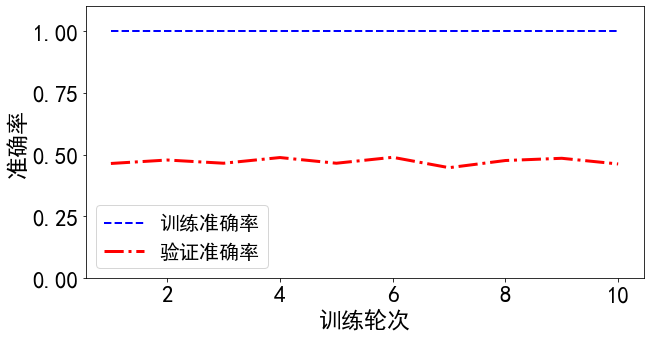

In [10]:
# 设置Y轴范围
plt.figure(figsize=(10,5))
plt.tick_params(labelsize=23)
plt.ylabel('准确率', fontsize=23)
plt.xlabel('训练轮次', fontsize=23)
plt.ylim(0,1.1)
# 训练准确率曲线
show_data1 = train_acc_list
# 测试准确率曲线
show_data2 = acc_list
x_data = list(range(1,len(show_data1)+1))
ln1, = plt.plot(x_data,show_data1,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['训练准确率','验证准确率'],fontsize=20)
plt.show()

Confusion matrix, without normalization
[[61 25 27 30 13]
 [20 68 21 10 16]
 [24 26 66 22  6]
 [27 24 20 56 17]
 [ 8 27  8 16 82]]


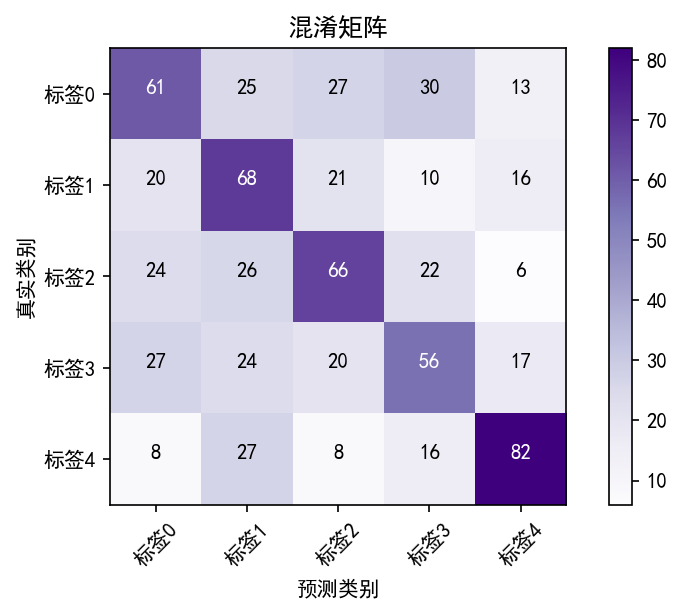

In [11]:
cmt_sklearn = confusion_matrix(val_label, y_pred)
plot_confusion_matrix(cmt_sklearn, ["标签0", "标签1", "标签2", "标签3", "标签4"], title = "混淆矩阵")

In [12]:
# 树的图像
# export_graphviz(tree,out_file="./tree/tree.dot",impurity=False,filled=True)
# with open("./tree/tree.dot") as f:
#     dot_graph=f.read()
#     graph=graphviz.Source(dot_graph)
# display(graph)

### 随机森林

In [13]:
# 模型参数设置
'''
第一类：
n_estimators：学习器的个数，interger，默认100
bootstrap：是否有放回抽样，boolean，默认True
第二类：
max_features：节点分裂时参与判断的最大特征数，默认auto，即sqrt(n_features)
max_depth：树的最大深度，int或None，默认None，表示对最大深度没有限制
min_samples_split：最小样本划分的数目，
min_samples_leaf：叶子节点最少样本数
'''

# rfc = RandomForestClassifier(n_estimators = 100,min_samples_split = 3,min_samples_leaf = 2,max_depth = 15)
rfc = RandomForestClassifier()
# 模型准确率和损失值
sum = 0
acc_list = []
loss_list = []
train_acc_list = []
print("开始训练")
start_time = time.time()
for i in range(1,epoch +1):

    # 模型训练
    rfc.fit(m_train,train_label)
    
    # 测试集
    y_pred = np.asarray(rfc.predict(m_val),dtype = 'int64')

    # 计算准确率
    acc = round(accuracy_score(val_label, y_pred),3)
    
    # 训练集
    y_pred = np.asarray(rfc.predict(m_train),dtype = 'int64')
    # 计算准确率
    train_acc = round(accuracy_score(train_label, y_pred),3)
    
    # print('测试集准确率:', round(accuracy_score(val_label, y_pred),3))
    acc_list.append(acc)
    train_acc_list.append(train_acc)
    
    # 计算损失值
    # 使用one-hot编码计算损失值
    noe_hot = OneHotEncoder(sparse = False)

    y_pred_o = noe_hot.fit_transform(y_pred.reshape(1, -1))
    val_label_o = noe_hot.fit_transform(val_label.reshape(1, -1))
    
    print("完成第",i,"轮训练，测试集准确率：",acc)
    sum += acc
print("平均准确率：", sum / i)
end_time = time.time()
print("训练耗费时间：", (end_time - start_time) / epoch)

开始训练
完成第 1 轮训练，测试集准确率： 0.962
完成第 2 轮训练，测试集准确率： 0.968
完成第 3 轮训练，测试集准确率： 0.971
完成第 4 轮训练，测试集准确率： 0.96
完成第 5 轮训练，测试集准确率： 0.954
完成第 6 轮训练，测试集准确率： 0.965
完成第 7 轮训练，测试集准确率： 0.96
完成第 8 轮训练，测试集准确率： 0.956
完成第 9 轮训练，测试集准确率： 0.967
完成第 10 轮训练，测试集准确率： 0.94
平均准确率： 0.9602999999999999
训练耗费时间： 7.273335075378418


In [14]:
y_pred = np.asarray(rfc.predict(m_val),dtype = 'int64')
print('------------------测试集上得分：------------------------')
print('*' * 5)
print('测试集准确率得分:', round(accuracy_score(val_label, y_pred),3))
print('*' * 5)
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_label, y_pred))

------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.94
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       156
           1       0.98      0.96      0.97       135
           2       0.97      1.00      0.98       144
           3       0.89      0.88      0.89       144
           4       0.99      0.99      0.99       141

    accuracy                           0.94       720
   macro avg       0.94      0.94      0.94       720
weighted avg       0.94      0.94      0.94       720



In [15]:
# from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_graphviz
# import graphviz
# tree = rfc.estimators_[0]
# export_graphviz(tree,out_file="./tree/tree_of_forest.dot")
# with open("./tree/tree_of_forest.dot") as f:
#     dot_graph=f.read()
#     graph=graphviz.Source(dot_graph)
    
# # display(graph)

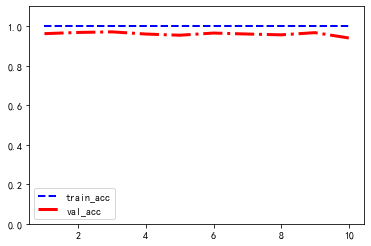

In [16]:
# 设置Y轴范围
plt.ylim(0,1.1)
# 训练准确率曲线
show_data1 = train_acc_list
# 测试准确率曲线
show_data2 = acc_list
x_data = list(range(1,len(show_data1)+1))
ln1, = plt.plot(x_data,show_data1,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['train_acc','val_acc'])
plt.show()

Confusion matrix, without normalization
[[136   1   3  16   0]
 [  1 130   2   0   2]
 [  0   0 144   0   0]
 [ 17   0   0 127   0]
 [  0   1   0   0 140]]


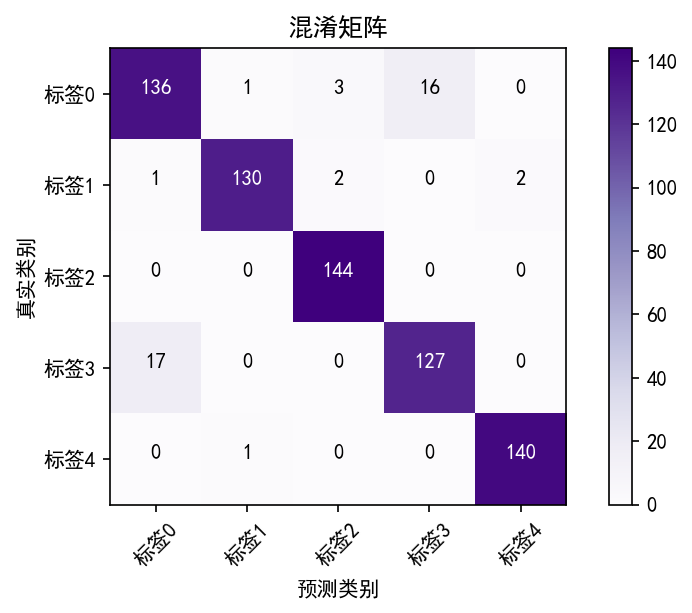

In [17]:
cmt_sklearn = confusion_matrix(val_label, y_pred)
plot_confusion_matrix(cmt_sklearn, ["标签0", "标签1", "标签2", "标签3", "标签4"], title = "混淆矩阵")

## CNN

In [18]:
from tensorflow import keras
from tensorflow.keras import layers, models
import time
Dense = layers.Dense
Dropout = layers.Dropout
Activation = layers.Activation
Conv1D = layers.Conv1D
MaxPooling1D = layers.MaxPooling1D
Flatten = layers.Flatten
# 查看GPU是否可用
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
def cnn_create():
    num_filters = 3
    filter_size = 1
    pool_size = 1

    model = models.Sequential([
      Conv1D(num_filters, filter_size, input_shape=(2000, 3)),
      MaxPooling1D(pool_size=pool_size),
      Flatten(),
      Dense(128, activation='relu'),
      Dense(label_count, activation='softmax'),
    ])
    
    model.compile('adam',  loss='sparse_categorical_crossentropy',  metrics=['accuracy'],)
    print("实例化模型成功，参数如下：")
    print(model.summary())
    return model

In [20]:
# 实例化模型
cnn_model = cnn_create()

# 设置模型log输出地址
log_dir = os.path.join("logs/CNN")
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

实例化模型成功，参数如下：
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2000, 3)           12        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2000, 3)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6000)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               768128    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 768,785
Trainable params: 768,785
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# 模型训练
start = time.clock()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = cnn_model.fit(train_data, train_label,epochs=20, batch_size=32, validation_split=0.2,callbacks=[tensorboard_callback])

Train on 1344 samples, validate on 336 samples
Epoch 1/20
1344/1344 [==============================] - 2s 2ms/sample - loss: 1.7051 - accuracy: 0.1920 - val_loss: 1.6304 - val_accuracy: 0.1964
Epoch 2/20
1344/1344 [==============================] - 0s 319us/sample - loss: 1.5859 - accuracy: 0.2500 - val_loss: 1.5513 - val_accuracy: 0.3274
Epoch 3/20
1344/1344 [==============================] - 0s 311us/sample - loss: 1.5351 - accuracy: 0.3095 - val_loss: 1.5319 - val_accuracy: 0.3512
Epoch 4/20
1344/1344 [==============================] - 0s 305us/sample - loss: 1.4251 - accuracy: 0.3921 - val_loss: 1.4552 - val_accuracy: 0.2262
Epoch 5/20
1344/1344 [==============================] - 0s 273us/sample - loss: 1.2667 - accuracy: 0.5759 - val_loss: 1.2300 - val_accuracy: 0.6399
Epoch 6/20
1344/1344 [==============================] - 0s 269us/sample - loss: 1.0916 - accuracy: 0.6451 - val_loss: 1.1156 - val_accuracy: 0.5863
Epoch 7/20
1344/1344 [==============================] - 0s 361us/sa

In [22]:
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,accuracy_score,log_loss
print("*****完成预处理，进行模型评估*****")
y_pred = cnn_model.predict(val_data)
y_pred = [np.argmax(x) for x in y_pred]

*****完成预处理，进行模型评估*****


In [23]:
print('------------------测试集上得分：------------------------')
print('*' * 5)
print('测试集准确率得分:', round(accuracy_score(val_label, y_pred),6))
print('*' * 5)
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_label, y_pred))

------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.994444
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       156
           1       1.00      0.98      0.99       135
           2       0.98      1.00      0.99       144
           3       0.99      1.00      1.00       144
           4       1.00      1.00      1.00       141

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



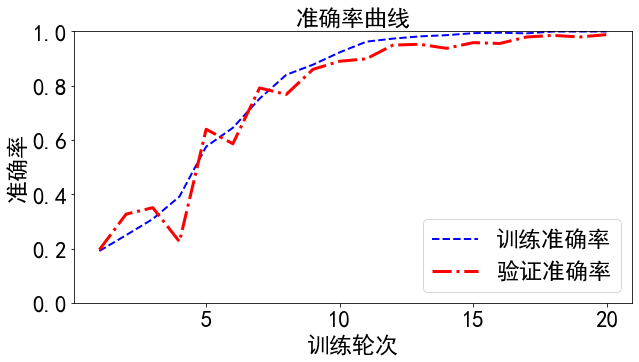

In [24]:
# 设置Y轴范围
plt.figure(figsize=(10,5))
plt.title("准确率曲线", fontsize=23)
plt.tick_params(labelsize=23)
plt.ylabel('准确率', fontsize=23)
plt.xlabel('训练轮次', fontsize=23)
plt.ylim(0,1)
# 训练准确率曲线
show_data1 = history.history['accuracy']
# 测试准确率曲线
show_data2 = history.history['val_accuracy']
x_data = list(range(1,len(show_data1)+1))
ln1, = plt.plot(x_data,show_data1,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['训练准确率','验证准确率'], fontsize=23)
plt.show()

Confusion matrix, without normalization
[[155   0   0   1   0]
 [  0 132   3   0   0]
 [  0   0 144   0   0]
 [  0   0   0 144   0]
 [  0   0   0   0 141]]


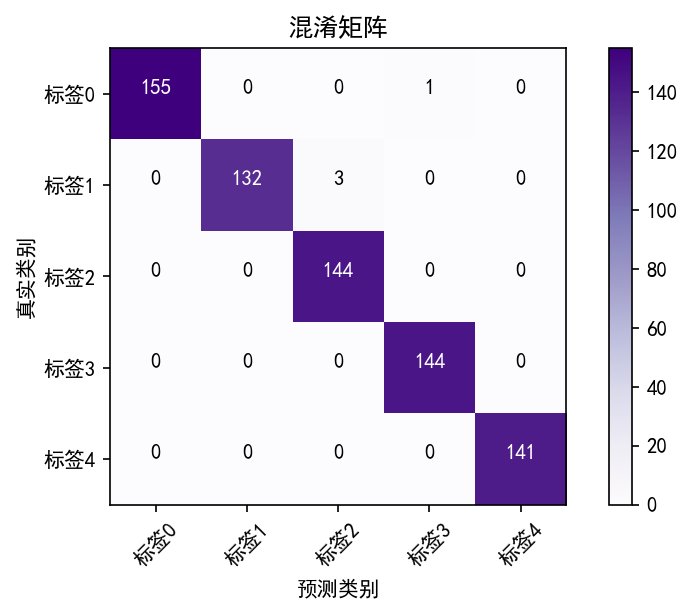

In [25]:
cmt_sklearn = confusion_matrix(val_label, y_pred)
plot_confusion_matrix(cmt_sklearn, ["标签0", "标签1", "标签2", "标签3", "标签4"], title = "混淆矩阵")